In [1]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
con = sqlite3.connect(r'/Users/xiao/Downloads/data project/zomato_data_analysis/zomato_rawdata.sqlite')

In [3]:
df = pd.read_sql_query('SELECT * FROM Users', con)

In [4]:
df['rate'].replace(('NEW', '-'), np.nan, inplace=True)

In [5]:
float_rate = []
for x in df['rate']:
    if type(x) == str:
        nx =float(x.replace('/5', ''))
    else:  nx = x
    float_rate.append(nx)

In [6]:
df['rate'] = float_rate

In [7]:
x = pd.crosstab(df['rate'], df['online_order'])

<Axes: xlabel='rate'>

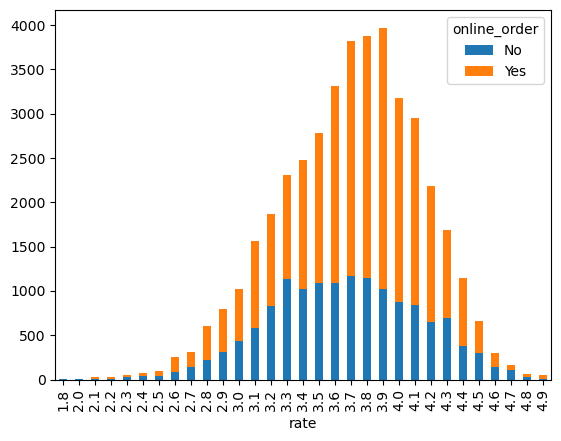

In [8]:
x.plot(kind='bar', stacked=True)

In [9]:
mormalized_x = x.div(x.sum(axis=1).astype(float), axis=0)

<Axes: xlabel='rate'>

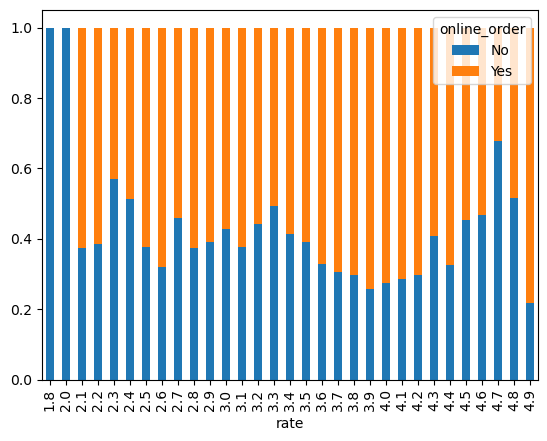

In [10]:
mormalized_x.plot(kind='bar', stacked=True)

In [11]:
data= df.dropna(subset=['rest_type'])

In [12]:
quick_b = data[data['rest_type'].str.contains('Quick Bites')]

In [ ]:
quick_b['reviews_list'] = quick_b['reviews_list'].apply(lambda x:x.lower())

In [14]:
from nltk.corpus import RegexpTokenizer

In [15]:
token = RegexpTokenizer('[a-zA-Z]+')

In [16]:
quick_b_token = quick_b['reviews_list'].apply(token.tokenize)

In [ ]:
import nltk
nltk.download('stopwords')

In [24]:
from nltk.corpus import stopwords

In [25]:
stop = stopwords.words('english')

In [26]:
stop.extend(['rated', 'n','x', 'nan','xa','f','c'])

In [27]:
review_clean = quick_b_token.apply(lambda review:[word for word in review if word not in stop])

In [28]:
review1d= []
for review in review_clean:
    for word in review:
        review1d.append(word)

In [29]:
from nltk import FreqDist, bigrams, trigrams

In [30]:
fd_bigrams = FreqDist()
bi_grams = bigrams(review1d)

In [31]:
for word in bi_grams:
    fd_bigrams[word] = fd_bigrams[word] +1 

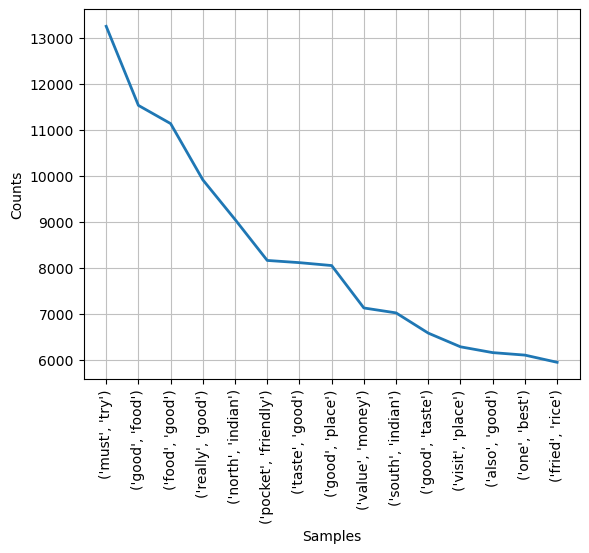

<Axes: xlabel='Samples', ylabel='Counts'>

In [32]:
fd_bigrams.plot(15)

In [33]:
fd_trigrams = FreqDist()
tri_grams = trigrams(review1d)
for word in tri_grams:
    fd_trigrams[word] = fd_trigrams[word] +1 

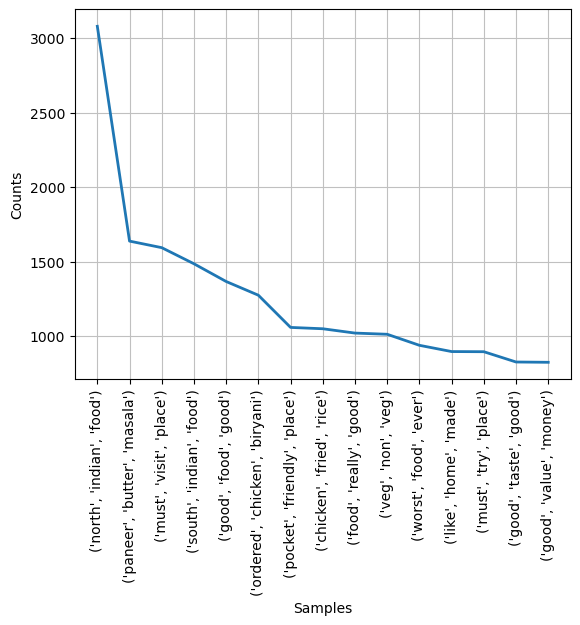

<Axes: xlabel='Samples', ylabel='Counts'>

In [34]:
fd_trigrams.plot(15)

In [ ]:
!pip install geocoder
!pip install geopy

In [36]:
df['location'] = df['location'] + ', Bangalore, Karnataka, India'

In [37]:
df_copy= df.dropna(subset = ['location'])

In [38]:
locations = pd.DataFrame(df_copy['location'].unique())

In [39]:
from geopy.geocoders import Nominatim

In [40]:
geolocator = Nominatim(user_agent='app',timeout=None)

In [41]:
lat=[]
lon=[]

for location in locations[0]:
    location = geolocator.geocode(location)
    if location is None:
        lat.append(np.nan)
        lon.append(np.nan)
    else:
        lat.append(location.latitude)
        lon.append(location.longitude)
    

In [42]:
locations['lat'] = lat
locations['lon'] = lon

In [51]:
locations[locations['lat'].isna()]

,0,lat,lon
79,"Rammurthy Nagar, Bangalore, Karnataka, India",NaN,NaN
85,"Sadashiv Nagar, Bangalore, Karnataka, India",NaN,NaN


In [ ]:
locations['lat'][79] = 13.0163
locations['lon'][79] = 77.6785
locations['lat'][85] = 13.0068
locations['lon'][85] = 77.5813

In [54]:
df = df.dropna(subset='cuisines')

In [114]:
not_india = df[df['cuisines'].str.contains('North Indian')]

In [115]:
not_india_count = not_india['location'].value_counts().reset_index()

In [119]:
locations = locations.rename(columns={0:'name'})

In [120]:
not_india_count = not_india_count.rename(columns={'location':'name'})

In [121]:
heatmap = not_india_count.merge(locations, on ='name', how ='left' )

In [ ]:
!pip install folium

In [126]:
import folium

In [127]:
basemap = folium.Map()

In [128]:
from folium.plugins import HeatMap

In [129]:
HeatMap(heatmap[['lat','lon','count']]).add_to(basemap)

In [130]:
basemap

In [165]:
def get_heatmap(cuisine):
    cuisine_df = df[df['cuisines'].str.contains('North Indian')]
    cuisine_count = cuisine_df['location'].value_counts().reset_index()
    cuisine_count = cuisine_count.rename(columns={'location':'name'})
    heatmap = cuisine_count.merge(locations, on ='name', how ='left' )
    print(heatmap.head(4))
    basemap = folium.Map()
    HeatMap(heatmap[['lat','lon','count']]).add_to(basemap)
    return basemap

In [167]:
get_heatmap('Cafe' )

                                        name  count        lat        lon
0           BTM, Bangalore, Karnataka, India   2469  12.911276  77.604565
1           HSR, Bangalore, Karnataka, India   1123  12.911623  77.638862
2    Whitefield, Bangalore, Karnataka, India   1059  12.969637  77.749745
3  Marathahalli, Bangalore, Karnataka, India   1038  12.955257  77.698416
